# Iterated Tweets Experiment

## Motivation

This was a high-risk, high-reward (ideally low-investment) project on how people process emoticons in Tweets. Many studies have used emoticons to label Tweets for supervised(-ish) classifier training, a procedure known as ["Distant Supervision"](http://web.stanford.edu/~jurafsky/mintz.pdf). In its basic implementation:

1. A corpus of Tweets is collected
2. Tweets containing positive ( :) ) and negative emoticons ( :( ) are identified and labeled as positive or negative
3. The emoticons are then stripped from those Tweets and the classifier is trained on them
4. The classifier is applied to a testing set.

And this works pretty well and has the perk of not requiring you to get a bunch of people on mturk to label Tweets by hand! 

The project is going to spice this up by adding some Psychology into the mix--How do people remember Tweets if we randomly add positive and negative emoticons to them? If this technique works, it could have some useful implications for classification tasks in general. There are many situations where there are not clear labeled examples such as situations in which emoticons are considered inappropriate (e.g., deaths) or where the baserate of category expression is low ([inferring political preferences based on Tweets is hindered by most Republicans and Democrats who aren't elected officials posting very little political content](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM13/paper/viewFile/6128/6347))

# Experiment

And so I scraped some Tweets and then set up an iterated learning experiment in lab. So in that experiment, I selected 48 neutral Tweets and added either positive, negative or no emoticon to them (evenly split). Participants would study all the Tweets for 15 seconds each and recall them after a 2 second delay. And then the next participant would recall the Tweets recalled by the previous participant, and so on. 

This document contains the results.

# Load packages

In [141]:
%matplotlib inline
import os
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweet_preprocess
sns.set_style("whitegrid")

# Setting up the data

In [251]:
tweets_df=pd.read_csv('itTwit_v2_data.csv',header=None)
tweets_df.columns=['index','subj','exp_id',
                   'chain','iter','tweet',
                   'observed','recalled','processed',
                   'claim_time','claim_by',
                   'emotion','emoticon',
                   'status']

I ran 9 chains for up to 11 iterations (some of the chains lagged behind). Each chain intially contained the same Tweets but diverged as participants recalled them.

In [8]:
tweets_df.head()

,index,subj,exp_id,chain,iter,tweet,observed,recalled,processed,claim_time,claim_by,emotion,emoticon,status
0,892,base0,itTwit_v2,0,0,0,NaN,NaN,Entourage then going to Eagles training camp t...,2016-04-04 11:46:26,C02SH,1.0,: (,complete
1,893,base0,itTwit_v2,0,0,1,NaN,NaN,#NCST extend their biggest lead of the game wi...,2016-04-04 11:46:26,C02SH,0.0,: ),complete
2,894,base0,itTwit_v2,0,0,2,NaN,NaN,#Everton News - Krul will miss the Monday nigh...,2016-04-04 11:46:26,C02SH,2.0,NaN,complete
3,895,base0,itTwit_v2,0,0,3,NaN,NaN,"Whew, long day unpacking the Turner house. Now...",2016-04-04 11:46:26,C02SH,0.0,:),complete
4,896,base0,itTwit_v2,0,0,4,NaN,NaN,Nothing is going to change between now and Wed...,2016-04-04 11:46:26,C02SH,0.0,:),complete


# Gross text analyses

First I'm going to run some analyses on just the text properties to see how the Tweets changed

In [14]:
basic_text_df=tweets_df.loc[:,['chain','iter','processed']]

### Tweet length

Calculate length of Tweets

In [48]:
basic_text_df.loc[:,'tweet_length']=basic_text_df.loc[:,'processed'].apply(len)
tweet_lengths=basic_text_df.groupby(['chain','iter']).mean().reset_index()

Calculate statistics

In [60]:
iter_group=tweet_lengths.loc[:,['iter','tweet_length']].groupby('iter')
tweet_length_stats=pd.DataFrame({})
tweet_length_stats.loc[:,'iter']=iter_group.mean().reset_index().loc[:,'iter']
tweet_length_stats.loc[:,'mean']=iter_group.mean().reset_index().loc[:,'tweet_length']
tweet_length_stats.loc[:,'std']=iter_group.std().reset_index().loc[:,'tweet_length']
tweet_length_stats.loc[:,'n']=iter_group.size().reset_index().loc[:,0]
tweet_length_stats.loc[:,'sem']=np.divide(tweet_length_stats.loc[:,'std'],np.sqrt(tweet_length_stats.loc[:,'n']))

In [61]:
tweet_length_stats.head()

,iter,mean,std,n,sem
0,0,112.255319,0.000000,9,0.000000
1,1,60.565350,9.859805,7,3.726656
2,2,54.088146,8.873994,7,3.354054
3,3,51.085106,7.498614,7,2.834210
4,4,48.623100,7.325308,7,2.768706


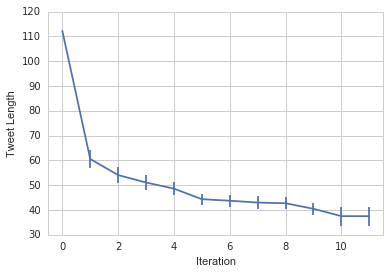

In [77]:
plt.errorbar(x=tweet_length_stats.loc[:,'iter'],y=tweet_length_stats.loc[:,'mean'],yerr=tweet_length_stats.loc[:,'sem'])
plt.xlabel('Iteration')
plt.ylabel('Tweet Length')
plt.xlim([-.5,11.5]);

### Tweet word number

Calculate number of words per Tweets

In [81]:
def num_words(txt):
    return len(txt.split(' '))

basic_text_df.loc[:,'num_words']=basic_text_df.loc[:,'processed'].apply(num_words)
num_words=basic_text_df.groupby(['chain','iter']).mean().reset_index()

Calculate statistics

In [82]:
iter_group=num_words.loc[:,['iter','num_words']].groupby('iter')
num_words_stats=pd.DataFrame({})
num_words_stats.loc[:,'iter']=iter_group.mean().reset_index().loc[:,'iter']
num_words_stats.loc[:,'mean']=iter_group.mean().reset_index().loc[:,'num_words']
num_words_stats.loc[:,'std']=iter_group.std().reset_index().loc[:,'num_words']
num_words_stats.loc[:,'n']=iter_group.size().reset_index().loc[:,0]
num_words_stats.loc[:,'sem']=np.divide(num_words_stats.loc[:,'std'],np.sqrt(num_words_stats.loc[:,'n']))

In [83]:
num_words_stats.head()

,iter,mean,std,n,sem
0,0,19.191489,0.000000,9,0.000000
1,1,12.063830,2.181309,7,0.824457
2,2,10.243161,1.320513,7,0.499107
3,3,9.741641,1.088815,7,0.411533
4,4,9.358663,1.064640,7,0.402396


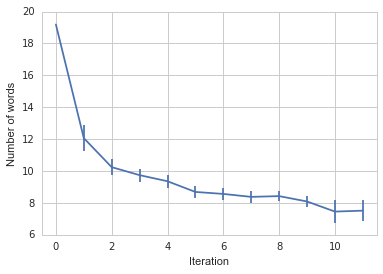

In [85]:
plt.errorbar(x=num_words_stats.loc[:,'iter'],y=num_words_stats.loc[:,'mean'],yerr=num_words_stats.loc[:,'sem'])
plt.xlabel('Iteration')
plt.ylabel('Number of words')
plt.xlim([-.5,11.5]);

So Tweets got shorter over time and converged to around 8 words

# Does classification improve over time?

And now let's see if Tweets got more positive/negative over iterations

## Labeled corpus

This is a set of Tweets I scraped a while back that another lab hand-labeled. Here I'm going to focus on just the positive and negative ones (I already used a subset of the neutral ones for the experiment)

In [146]:
## Load tweets and positive (1), negative (0) labels
def load_tweets(fname):
    # Load tweets text

    if not os.path.exists(fname):
        print 'Processing tweets...'

        fold_name='../semval'
        #file_name='tweet-a.tsv' # a is context rating
        file_name='tweet-b-actual.tsv' # b is message rating
        full_name=os.path.join(fold_name,file_name)
        tweet_text_temp,tweet_label_temp=tweet_preprocess.load_tweets(full_name)

        tweet_text=[]
        tweet_label=[]
        for ttt,tlt in zip(tweet_text_temp,tweet_label_temp):

            if tlt=='positive' or tlt=='negative':
                tweet_text.append(ttt)

                # labels
                if tlt=='positive':
                    tweet_label.append(1)
                else:
                    tweet_label.append(0)
        with open(fname, 'w') as f:
            pk.dump([tweet_text,tweet_label], f)
    else:
        print 'Loading processed tweets...'
        with open(fname) as f:
            tweet_text,tweet_label = pk.load(f)
        print 'Load complete'


    return tweet_text,tweet_label

fname='../semval/loaded_tweets_unedited.pickle'
tweet_text_raw,tweet_label_raw=load_tweets(fname)

Processing tweets...
['positive', 'negative', 'neutral']
[2287, 837, 3035]


In [151]:
labeled_df=pd.DataFrame({'processed':tweet_text_raw,'label':tweet_label_raw})

## Sentiment classifier

I'm going to use a Naive Bayes classifier to estimate the sentiment of the Tweets

Relevant packages

In [168]:
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.naive_bayes import BernoulliNB

In [159]:
def nb_classifier(tweet_train, tweet_test, label_train, label_test,K):
    # Run Naive Bayes classifier on binary presence
    # Returns 1) word2vec transformation, 2) the nb classifier that turns the vector representation into a sentiment
    # 3) training accuracy and 4) testing accuracy
    # note, this requires the 

    ## Vectorize training words
    train_count_vec=CountVectorizer(binary=True)
    train_count_words=train_count_vec.fit_transform(tweet_train)
    test_count_words=train_count_vec.transform(tweet_test)
    train_feat_names=train_count_vec.get_feature_names()

    # Reduce feature space to K best features
    ch2 = SelectKBest(chi2, k=K)
    X_train = ch2.fit_transform(train_count_words, label_train)
    X_test = ch2.transform(test_count_words)

    feature_names=train_count_vec.get_feature_names()
    k_feature_inds=[]
    for ii in ch2.get_support(indices=True): 
        k_feature_inds.append(feature_names[ii])

    # NB model
    nb_class=BernoulliNB()
    nb_class.fit(X_train,label_train)
    

    train_acc=nb_class.score(X_train,label_train)
    test_acc=nb_class.score(X_test,label_test)

    return ch2,nb_class,train_acc,test_acc

And a function to clean and stem the text

In [ ]:
# Identify stopwords to remove
sw=stopwords.words('english')

# create stemmer to stem words
stemmer=SnowballStemmer("english")

def clean_text(txt):
    txt=txt.split(' ')
    txt=[stemmer.stem(tt.decode('utf-8')) for tt in txt if not tt.decode('utf-8') in sw]
    txt=' '.join(txt)
    return txt

And let's clean our experimental and labeled tweets

In [153]:
tweets_df.loc[:,'stemmed']=tweets_df.loc[:,'processed'].apply(clean_text)
labeled_df.loc[:,'stemmed']=labeled_df.loc[:,'processed'].apply(clean_text)

tweets_df.head()

,index,subj,exp_id,chain,iter,tweet,observed,recalled,processed,claim_time,claim_by,emotion,emoticon,status,stemmed
0,892,base0,itTwit_v2,0,0,0,NaN,NaN,Entourage then going to Eagles training camp t...,2016-04-04 11:46:26,C02SH,1.0,: (,complete,entourag go eagl train camp tomorrow @kevinmca...
1,893,base0,itTwit_v2,0,0,1,NaN,NaN,#NCST extend their biggest lead of the game wi...,2016-04-04 11:46:26,C02SH,0.0,: ),complete,#ncst extend biggest lead game lorenzo brown t...
2,894,base0,itTwit_v2,0,0,2,NaN,NaN,#Everton News - Krul will miss the Monday nigh...,2016-04-04 11:46:26,C02SH,2.0,NaN,complete,#everton news - krul miss monday night clash e...
3,895,base0,itTwit_v2,0,0,3,NaN,NaN,"Whew, long day unpacking the Turner house. Now...",2016-04-04 11:46:26,C02SH,0.0,:),complete,"whew, long day unpack turner house. now movi k..."
4,896,base0,itTwit_v2,0,0,4,NaN,NaN,Nothing is going to change between now and Wed...,2016-04-04 11:46:26,C02SH,0.0,:),complete,noth go chang wednesday. if acta went long w/o...


## Aggregate performance

If we take all of our Tweets, how does the classifier do?

In [203]:
emotion_df=tweets_df.loc[np.logical_or(tweets_df.emotion==0,tweets_df.emotion==1),:]
emotion_df.loc[:,'label']=emotion_df.loc[:,'emotion']==0
tweet_train=emotion_df.loc[:,'stemmed']
label_train=emotion_df.loc[:,'label']

In [238]:
pos_df=labeled_df.loc[labeled_df.label==1,:]
pos_df=pos_df.sample(n=400,replace=False)

neg_df=labeled_df.loc[labeled_df.label==0,:]
neg_df=neg_df.sample(n=400,replace=False)

labeled_resamp_df=pos_df.append(neg_df)
tweet_test=labeled_resamp_df.loc[:,'stemmed']
label_test=labeled_resamp_df.loc[:,'label']

In [248]:
K=100
ch2,nb_class,train_acc,test_acc=nb_classifier(tweet_train, tweet_test, label_train, label_test,K)
print test_acc

0.50125


Ouch...not good

## By iteration

Do later Tweets improve classifier performance?

In [249]:
num_iter=np.unique(tweets_df.iter)
all_test_acc=[]
for ii in num_iter:
    curr_tweets=tweets_df.loc[tweets_df.iter==ii,:]
    emotion_df=curr_tweets.loc[np.logical_or(curr_tweets.emotion==0,curr_tweets.emotion==1),:]
    emotion_df.loc[:,'label']=emotion_df.loc[:,'emotion']==0
    tweet_train=emotion_df.loc[:,'stemmed']
    label_train=emotion_df.loc[:,'label']
    K=100
    ch2,nb_class,train_acc,test_acc=nb_classifier(tweet_train, tweet_test, label_train, label_test,K)
    all_test_acc.append(test_acc)  


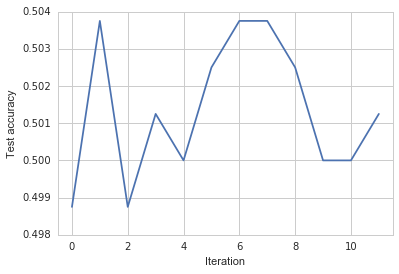

In [250]:
plt.plot(num_iter.tolist(),all_test_acc)
plt.xlabel('Iteration')
plt.ylabel('Test accuracy')
plt.xlim([-.5,11.5]);

Ooof, that's a lot of noise x.X

# Interim conclusions

Ok, so this isn't working--The Tweets are not conveying more information about positive and negative sentiments as they are passed on over time. There may be some manipulations we can try to get more signal out:

1. Make our manipulation much stronger-It's possible that people didn't really pay attentiont to the emoticons. In a future version of the experiment, we could try giving stronger cues about the emotions of the Tweets (e.g., like give a cover story that we're interested in whether happy tweets are more memorable than sad tweets and use a condition-blocked design).
2. Give people more time to read Tweets and give people fewer Tweets-There's a pretty sharp decline in the length of Tweets over iterations. Also, many subjects reported getting bored or frustrated with the experiment. Making the experiment easier for them might give us better quality Tweets
3. More data-We only used 48 Tweets total, and we're only using 2/3's of those because we're focusing on the emotional ones. Adding more chains with different initial Tweets will likely help.

None of these are mutually exclusive so the next version of this will hopefully be much more powerful